In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import calibrate_camera
import image_pipeline

## Calibrate Camera

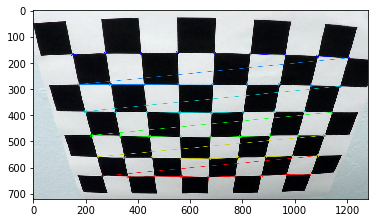

In [2]:
camera_cal_path = './camera_cal'
fname = camera_cal_path + '/calibration2.jpg'
img = cv2.imread(fname)

calibrate_camera.draw_chessboard_corners(img)

./camera_cal/calibration6.jpg
./camera_cal/calibration7.jpg
./camera_cal/calibration3.jpg
./camera_cal/calibration2.jpg
./camera_cal/calibration20.jpg
./camera_cal/calibration19.jpg
./camera_cal/calibration18.jpg
./camera_cal/calibration15.jpg
./camera_cal/calibration14.jpg
./camera_cal/calibration16.jpg
./camera_cal/calibration17.jpg
./camera_cal/calibration13.jpg
./camera_cal/calibration12.jpg
./camera_cal/calibration10.jpg
./camera_cal/calibration11.jpg
./camera_cal/calibration9.jpg
./camera_cal/calibration8.jpg


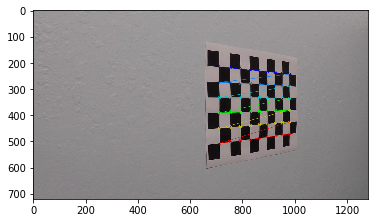

In [3]:
calibration_image_paths = glob.glob('./camera_cal/calibration*.jpg')

objpoints, imgpoints = calibrate_camera.find_image_points(calibration_image_paths)

In [4]:
# These are the coeffeicients that will be used later to undistort the road images
mtx, dist = calibrate_camera.cal_undistort_coeffs(img, objpoints, imgpoints)

undistorted_images = []
for fname in calibration_image_paths:
    img = cv2.imread(fname)
    undistorted = calibrate_camera.undistort_image(img, mtx, dist)
    undistorted_images.append(undistorted)
    

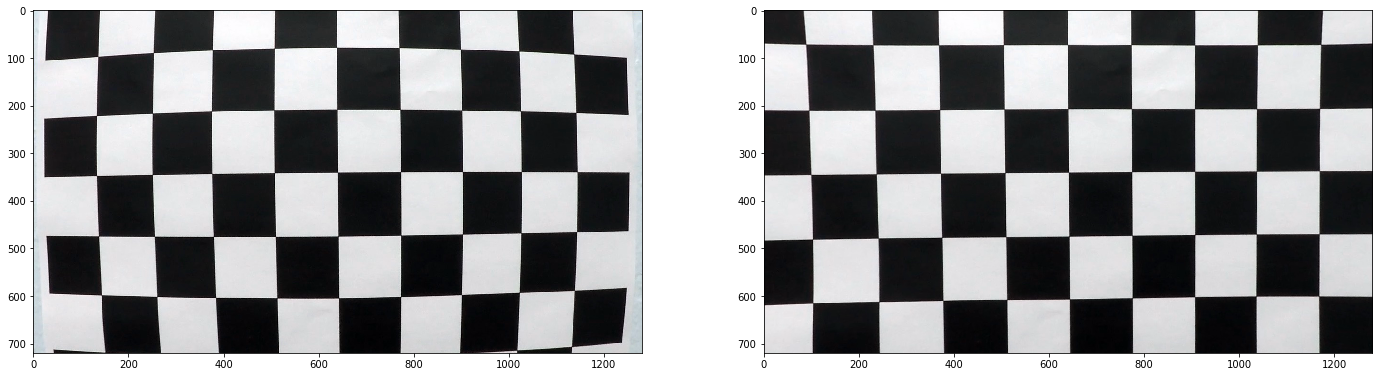

In [5]:
original = cv2.imread(calibration_image_paths[6])
undistorted = undistorted_images[6]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
ax1.imshow(original)
ax2.imshow(undistorted)


## Find the Lanes
## Sobel, Magnitude, Direction & HLS
* be careful how you read the images in (either through cv2 or matplotlit)

In [6]:
def hls_select_lightness(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    L = hls[:,:,1]
    binary_output = np.zeros_like(L)
    binary_output[(L > thresh[0]) & (L <= thresh[1])] = 1
    return binary_output

test_image = mpimg.imread('./test_images/test5.jpg')

ksize = 15

gradx = image_pipeline.abs_sobel_thresh(test_image, orient='x', sobel_kernel=ksize, thresh=(50, 100))
grady = image_pipeline.abs_sobel_thresh(test_image, orient='y', sobel_kernel=ksize, thresh=(50, 100))
mag_binary = image_pipeline.mag_thresh(test_image, sobel_kernel=ksize, mag_thresh=(70, 100))
dir_binary = image_pipeline.dir_threshold(test_image, sobel_kernel=3, thresh=(0.3, 0.9))
s_binary = image_pipeline.hls_select(test_image, thresh=(90, 255))
l_binary = image_pipeline.hls_select_lightness(test_image, thresh=(100, 255))

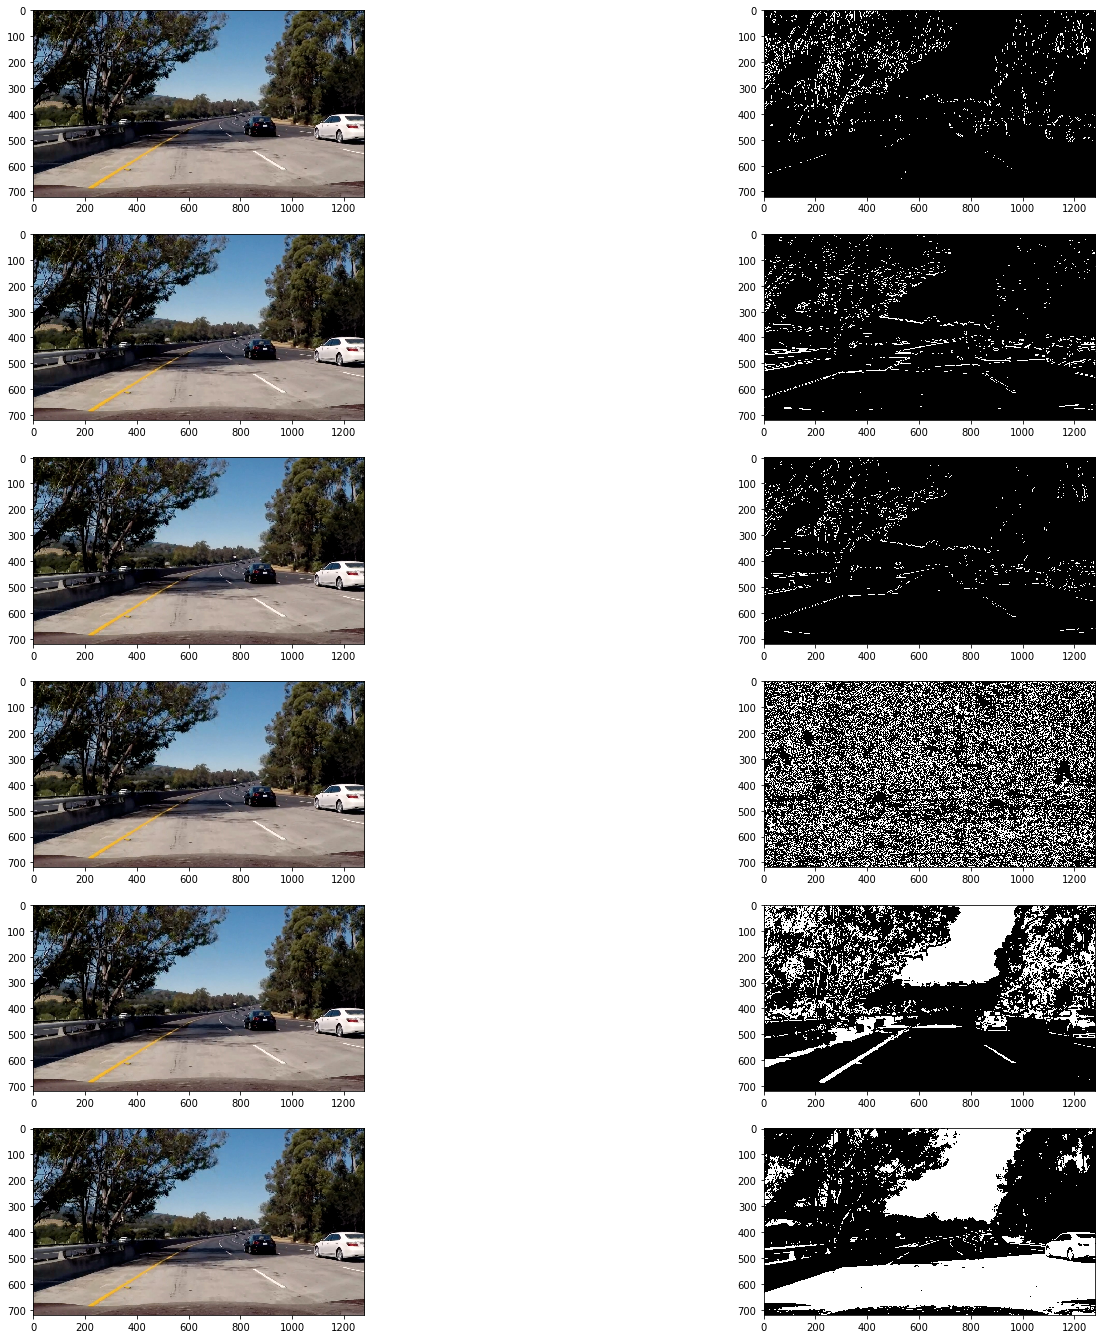

In [7]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10), (ax11, ax12)) = plt.subplots(6, 2, figsize=(24,24))
ax1.imshow(test_image)
ax2.imshow(gradx, cmap='gray')

ax3.imshow(test_image)
ax4.imshow(grady, cmap='gray')

ax5.imshow(test_image)
ax6.imshow(mag_binary, cmap='gray')

ax7.imshow(test_image)
ax8.imshow(dir_binary, cmap='gray')

ax9.imshow(test_image)
ax10.imshow(s_binary, cmap='gray')

ax11.imshow(test_image)
ax12.imshow(l_binary, cmap='gray')

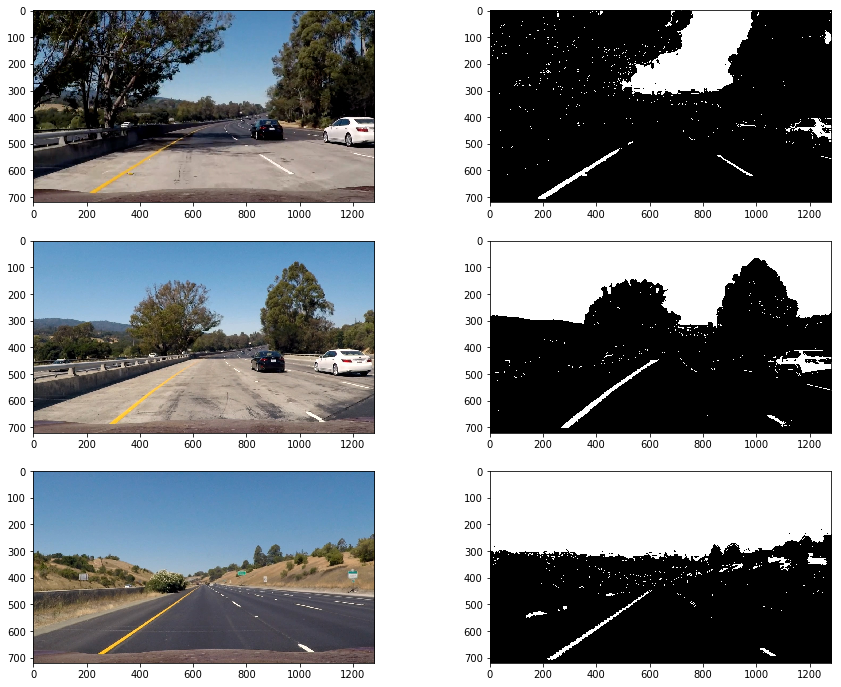

In [11]:
%matplotlib inline 
import importlib
importlib.reload(image_pipeline)

test5 = mpimg.imread('./test_images/test5.jpg')
test1 = mpimg.imread('./test_images/test1.jpg')
straight1 = mpimg.imread('./test_images/straight_lines1.jpg')

pipelined_image5 = image_pipeline.pipeline(test5, mtx, dist)
pipelined_image1 = image_pipeline.pipeline(test1, mtx, dist)
pipelined_image_straight1 = image_pipeline.pipeline(straight1, mtx, dist)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15,12))
ax1.imshow(test_image)
ax2.imshow(pipelined_image5, cmap='gray')

ax3.imshow(test1)
ax4.imshow(pipelined_image1, cmap='gray')

ax5.imshow(straight1)
ax6.imshow(pipelined_image_straight1, cmap='gray')

## Warp the Image

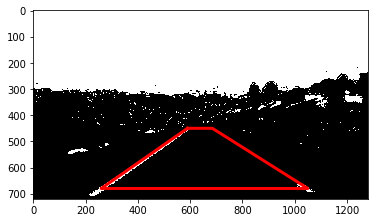

In [12]:
# pick four point for warped image
straight_line_image = mpimg.imread('./test_images/straight_lines1.jpg')
filt = image_pipeline.pipeline(straight_line_image, mtx, dist)

top_left = [590, 450]
top_right = [685, 450]
bottom_left = [260, 680]
bottom_right = [1050, 680]
# Draw a polygon on the image
plt.plot([590, 685, 1050, 260, 590], [450, 450, 680, 680, 450], 'r-', lw=3)
plt.imshow(filt, cmap='gray')

In [13]:
def warp(img):
    img_size = (img.shape[1], img.shape[0]) # (img.shape = (720, 1280))
    
    src = np.float32([
        [590, 450],
        [685, 450],
        [260, 680],
        [1050, 680]
    ])
    
    dst = np.float32([
        [260, 0],
        [1050, 0],
        [260, 720],
        [1050, 720],
    ])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

def inverse_perspective_transform():
    src = np.float32([
        [590, 450],
        [685, 450],
        [260, 680],
        [1050, 680]
    ])
    
    dst = np.float32([
        [260, 0],
        [1050, 0],
        [260, 720],
        [1050, 720],
    ])
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    return Minv

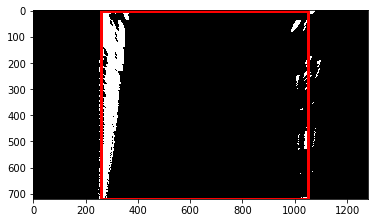

In [14]:
warped = warp(filt)
plt.plot([260, 1050, 1050, 260, 260], [0, 0, 720, 720, 0], 'r-', lw=3)
plt.imshow(warped, cmap='gray')

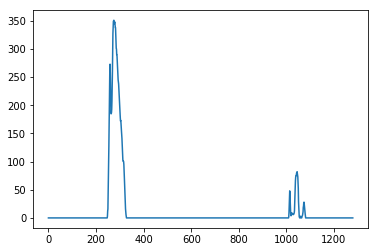

In [15]:
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

## Sliding Window Approach

In [16]:
straight_line_image = mpimg.imread('./test_images/test5.jpg')
filt = image_pipeline.pipeline(straight_line_image, mtx, dist)
binary_warped = warp(filt)

def sliding_window(binary_warped):
    # Histo of bottom half
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0) 
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high),(0,255,0), 4)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high),(0,255,0), 4)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                         (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]

        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzeroy, nonzerox
        

left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzeroy, nonzerox = sliding_window(binary_warped)

(720, 0)

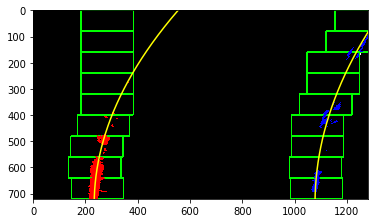

In [17]:
def generate_line_fit(warped, left_fit, right_fit, out_img, nonzeroy, nonzerox, left_lane_inds, right_lane_inds):
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return out_img, left_fitx, right_fitx, ploty

window_img, left_fitx, right_fitx, ploty = generate_line_fit(binary_warped, left_fit, right_fit, out_img, nonzeroy, nonzerox, left_lane_inds, right_lane_inds)
plt.imshow(window_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Skip the sliding windows once you know where the lines are

In [18]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def skip_sliding_window(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 150
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                       left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                       left_fit[1]*nonzeroy + left_fit[2] + margin)))

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                        right_fit[1]*nonzeroy + right_fit[2] + margin)))


    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit, nonzeroy, nonzerox, left_lane_inds, right_lane_inds


left_fitx, right_fitx, ploty, left_fit, right_fit, nonzeroy, nonzerox, left_lane_inds, right_lane_inds = skip_sliding_window(binary_warped, left_fit, right_fit)


(720, 0)

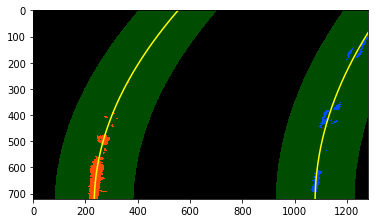

In [19]:
# Create an image to draw on and an image to show the selection window
MARGIN = 150
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-MARGIN, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+MARGIN, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))

right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-MARGIN, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+MARGIN, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Measuring Curvature

In [20]:
# Pixel Space
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

861.903312296 1042.4177243


In [85]:
def line_curvature(ploty, left_fitx, right_fitx):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Now our radius of curvature is in meters
    return left_curverad, right_curverad

def vehicle_position(image_width, left_fitx, right_fitx):
    left_mean = np.mean(left_fitx)
    right_mean = np.mean(right_fitx)
    pos = (image_width/2) - np.mean([left_mean, right_mean])
    return (3.7/700) * pos
    
    

## Draw

-0.608780090484


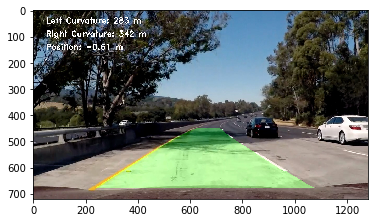

In [89]:
def draw_debug_info(image, text):
    cv2.putText(image, text, (50, 200), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)

def draw_text_curvature_values(image, left_curvature, right_curvature):
    cv2.putText(image, 'Left Curvature: {:.0f} m'.format(left_curvature), (50, 50), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(image, 'Right Curvature: {:.0f} m'.format(right_curvature), (50, 100), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)

def draw_poly(original, warped, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    Minv = inverse_perspective_transform()

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (original.shape[1], original.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original, 1, newwarp, 0.3, 0)
    
    return result

def draw_vehicle_position(image, vehicle_position):
    cv2.putText(image, 'Position: {:.2f} m'.format(vehicle_position), (50, 150), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)

pos = vehicle_position(warped_with_poly.shape[1], left_fitx, right_fitx)
warped_with_poly = draw_poly(straight_line_image, binary_warped, left_fitx, right_fitx, ploty)
l_curverad, r_curverad = line_curvature(ploty, left_fitx, right_fitx)
draw_text_curvature_values(warped_with_poly, l_curverad, r_curverad)
draw_vehicle_position(warped_with_poly, pos)
plt.imshow(warped_with_poly)
print(pos)

In [23]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [49]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = np.array([0.0, 0.0, 0.0])
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = []  
        #y values for detected line pixels
        self.ally = []

In [97]:
def update_lane_data(left_fit, right_fit, left_fitx, right_fitx, ploty):
    left_lane.best_fit = left_fit
    right_lane.best_fit = right_fit
    left_lane.allx = left_fitx
    right_lane.allx = right_fitx
    left_lane.ally = ploty
    right_lane.ally = ploty
    
def sanity_check_pass(left_fit, right_fit):
    # Similar Curvature
    diff = abs(left_lane.radius_of_curvature - right_lane.radius_of_curvature)
    if diff > 500:
        return False
    # Check that Fit Coeffecients are not very different
    left_fit_diff = np.abs(left_fit[0] - left_lane.best_fit[0])
    left_check = min(abs(left_fit[0]), abs(left_lane.best_fit[0])) / left_fit_diff
    right_fit_diff = np.abs(right_fit[0] - right_lane.best_fit[0])
    right_check = min(abs(right_fit[0]), abs(right_lane.best_fit[0])) / right_fit_diff
    if left_check <= 0.5 or right_check <= 0.5:
        return False
    # Lines separated by approximately the right distance
    # Roughly Parallel
    return True

def lanes_found(binary_warped):
    min_peak_found = 50
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:, :], axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    if leftx_base < min_peak_found or rightx_base < min_peak_found:
        return False
    return True
    
def process_image(img):
    global frames_used
    global frames_not_detected_line
    frames_used += 1

    # Run the image through the image pipeline (grayscale, gradients, etc...)
    pipelined_image = image_pipeline.pipeline(img, mtx, dist)
    
    # Warp the image
    warped = warp(pipelined_image)
    
    debug_text = ''
    
    # (left_fit, right_fit) -> Polynomials(0, 1, 2); (left_fitx, right_fitx) -> All x values;
    if left_lane.detected == False and right_lane.detected == False:
        # Sliding Window Method to Find Lane Lines
        left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzeroy, nonzerox = sliding_window(warped)
        out_img, left_fitx, right_fitx, ploty = generate_line_fit(warped, left_fit, right_fit, 
                                                                  out_img, nonzeroy, nonzerox, 
                                                              left_lane_inds, right_lane_inds)
        left_curvature, right_curvature = line_curvature(ploty, left_fitx, right_fitx)
        left_lane.radius_of_curvature = left_curvature
        right_lane.radius_of_curvature = right_curvature
        debug_text = "Sliding Window"
        left_lane.detected = True
        right_lane.detected = True
        update_lane_data(left_fit, right_fit, left_fitx, right_fitx, ploty)

    else:
        # Skip Sliding Window Method
        debug_text = "Skip Sliding Window"
        if lanes_found(warped) and frames_not_detected_line <= 5:
            left_fitx, right_fitx, ploty, left_fit, right_fit,_,_,_,_ = skip_sliding_window(binary_warped, 
                                                                                    left_lane.best_fit,
                                                                                    right_lane.best_fit)
            
            # Check and see if everything makes sense with the new value
            if sanity_check_pass(left_fit, right_fit) == True:
                update_lane_data(left_fit, right_fit, left_fitx, right_fitx, ploty)
                
                left_curvature, right_curvature = line_curvature(ploty, left_fitx, right_fitx)
                left_lane.radius_of_curvature = left_curvature
                right_lane.radius_of_curvature = right_curvature
            else:
                frames_not_detected_line += 1
                
        else:
            left_lane.detected = False
            right_lane.detected = False
            frames_not_detected_line = 0
            debug_text = "Lanes not found"
    
    # Vehicle Position on Road
    position = vehicle_position(warped.shape[1], left_lane.allx, right_lane.allx)
    
    # Draw Poly
    poly_image = draw_poly(img, warped, left_lane.allx, right_lane.allx, left_lane.ally)
    # Draw Curvatures
    draw_text_curvature_values(poly_image, left_lane.radius_of_curvature, right_lane.radius_of_curvature)
    # Draw Position
    draw_vehicle_position(poly_image, position)
    # Debug Info
    #draw_debug_info(poly_image, "{} - {} - {}".format(debug_text, frames_not_detected_line, right_lane.best_fit))
    
    return poly_image

In [99]:
project_video_output = 'videos/project_video_with_poly.mp4'

clip1 = VideoFileClip('project_video.mp4')#.subclip(1, 2)

left_lane = Line()
right_lane = Line()
frames_used = 0
frames_not_detected_line = 0

project_video = clip1.fl_image(process_image)
%time project_video.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video videos/project_video_with_poly.mp4
[MoviePy] Writing video videos/project_video_with_poly.mp4


100%|█████████▉| 1260/1261 [07:49<00:00,  2.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/project_video_with_poly.mp4 

CPU times: user 10min 33s, sys: 1min 26s, total: 12min
Wall time: 7min 50s
